In [1]:
import sys
sys.path.append('..')

# Standard libraries
import math
import random
import datetime
import time

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import History, EarlyStopping

# Keras Tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters
import keras_tuner as kt

# Bayesian Optimization
from bayes_opt import BayesianOptimization

# Custom modules
import Models.SqlCom as sq
import Models.Shares as sm
import Models.utils as ut

# Les fonctions

In [5]:
# dataX = look_back_x cotations séparé par stride
# dataY = nb_y points réparti équitableme
def create_X_Y(dataset, data_info):
    look_back_x = data_info['look_back_x']
    nb_quots_by_day = data_info['nb_quots_by_day']
    stride_x = data_info['stride_x']
    nb_y = data_info['nb_y']
    return_type = data_info.get('return_type', 'value')  # default to 'value' if not provided
    data_X, data_Y = [], []
    # Pour chaque point de départ de journée possible
    for i in range(0, len(dataset), nb_quots_by_day):
        # EX : journée 1 = data_X = data[0,2,4,...120]
        a = dataset.iloc[i:i + look_back_x*stride_x:stride_x, :]  # premières minutes de la journée
        if return_type == 'yield':
            a /= a.iloc[-1, :]  # divide by the last train value of the day dans le cas pourcentage
        data_X.append(a)
        y_values = []
        # ex: 540 quots - 60 * 2 // 2+1 = 420 / 3 = 140
        # (nb_quots_by_day - look_back_x*stride_x) = (on retire la quantité de data du début qui a servi à l'entrainement)
        # (nb_y+1) nb de Y par jour, +1 car ce que l'on veut c'est nb_y + 1 interval pour nb_y point qui ne soit ni au début ni à la fin
        stride_y = (nb_quots_by_day - look_back_x*stride_x) // (nb_y+1) # écart des Y pour une bonne répartition sur la journée
        # [140, 280]
        offsets = [stride_y*j for j in range(1,nb_y+1)] #  POsition des Y
        for offset in offsets:
            # [60*2 + 140, 60*2 + 280] = [260, 400]
            y_value = dataset.iloc[i + look_back_x*stride_x + offset, 0]  # On ne prend que les cotations car ca ne sert à rien de prédire un volume on veut juste une valeur
            if return_type == 'yield':
                y_value /= dataset.iloc[i+look_back_x*stride_x, 0]  # divide by the last train value of the day dans le cas pourcentage
            y_values.append(y_value)
        data_Y.append(y_values)
    return np.array(data_X), np.array(data_Y)

# Fonction pour créer les ensembles d'entraînement et de test
# Il faut que le dataset ait été cleaner (et surtout ne pas avoir pris les cotations de la derniere journée incomplete)
def split_dataset_train_test(dataset, data_info):
    shareObj = data_info['shareObj']
    nb_days_to_take_dataset = data_info['nb_days_to_take_dataset']
    percent_train_test = data_info['percent_train_test']
    
    # Déterminer le nombre de minutes jusqu'à l'ouverture et la fermeture du marché
    nb_minute_until_open = shareObj.openRichMarketTime.hour * 60 + shareObj.openRichMarketTime.minute
    nb_minute_until_close = shareObj.closeRichMarketTime.hour * 60 + shareObj.closeRichMarketTime.minute
    # Calculer le nombre de cotations par jour
    nb_quots_by_day = (nb_minute_until_close - nb_minute_until_open) + 1
    if (data_info['look_back_x']*data_info['stride_x'] < nb_quots_by_day):
        data_info['nb_quots_by_day'] = nb_quots_by_day
    else:
        print("look_back_x*stride_x > nb_quots_by_day")
        exit(1)

    nb_days_total = len(dataset) // nb_quots_by_day
    data_info['nb_days_total'] = nb_days_total
    
    if (nb_days_to_take_dataset == 'max' or nb_days_to_take_dataset > nb_days_total):
        # Calculer le nombre total de jours de cotations dans le dataset
        nb_days_to_take = nb_days_total
    else:
        nb_days_to_take = nb_days_to_take_dataset
        
    # Calculer le nombre de jours de cotations à sauter pour créer un ensemble de données d'entraînement équilibré
    # Car on ne prend que les jours de cotations les plus récents
    nb_days_skipped =  (nb_days_total - nb_days_to_take)

    nb_day_train = math.floor(nb_days_to_take * (percent_train_test/100))
    nb_day_test = nb_days_to_take - nb_day_train

    nb_quots_skipped = nb_days_skipped * nb_quots_by_day

    nb_quots_train = nb_day_train * nb_quots_by_day
    nb_quots_test = nb_day_test * nb_quots_by_day # Non utile car les quots de tests sont les quots restantes
    # Créer les ensembles d'entraînement et de test en fonction des tailles calculées
    train = dataset.iloc[nb_quots_skipped:nb_quots_skipped + nb_quots_train, :]
    test = dataset.iloc[nb_quots_skipped + nb_quots_train:len(dataset), :]
    return train, test

# Fonction pour créer les ensembles d'entraînement et de test avec un look_back spécifique
def create_train_test(dataset, data_info):
    train, test = split_dataset_train_test(dataset, data_info)
    trainX, trainY = create_X_Y(train, data_info)
    testX, testY = create_X_Y(test, data_info)
    return trainX, trainY, testX, testY

# Fonction pour déterminer la plage de dates et préparer les données de cotation
def get_and_clean_data(shM, shareObj, columns):
    # Si la cotation ne se termine pas en fin de journée alors on exclue cette journée pour avoir des journées complètes
    if shareObj.lastRecord.time() < shareObj.closeRichMarketTime:
        end_date = shareObj.lastRecord - datetime.timedelta(days=1)
        end_date = end_date.replace(hour=shareObj.closeRichMarketTime.hour, 
                                    minute=shareObj.closeRichMarketTime.minute, 
                                    second=shareObj.closeRichMarketTime.second)
    else:
        end_date = shareObj.lastRecord

    data_quots = shM.get_cotations_data_df(shareObj, shareObj.firstRecord, end_date)
    # On interpole les valeurs null
    df = ut.prepareData(shareObj, data_quots, columns)
    return df

def directional_accuracy(y_true, y_pred):
    # Assuming last_known_value is the first value in y_true
    last_known_value = y_true[:, 0]
    # Repeat last_known_value to match the shape of y_true
    last_known_value = tf.expand_dims(last_known_value, axis=-1)
    last_known_value = tf.tile(last_known_value, [1, y_true.shape[1]])
    true_direction = tf.math.sign(y_true - last_known_value)
    pred_direction = tf.math.sign(y_pred - last_known_value)

    correct_predictions = tf.cast(tf.equal(true_direction, pred_direction), dtype=tf.float32)
    return tf.reduce_mean(correct_predictions)
    # Custom run_trial method to choose between 'val_loss' and 'directional_accuracy'
    
class CustomHyperband(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        # Choisir aléatoirement entre 'val_loss' et 'directional_accuracy'
        objective = random.choice(['val_loss', 'directional_accuracy'])
        self.oracle.objective = kt.Objective(objective, direction='min' if objective == 'val_loss' else 'max')
        results = super().run_trial(trial, *args, **kwargs)
        return results

class CustomRandomSearch(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Choisir aléatoirement entre 'val_loss' et 'directional_accuracy'
        objective = random.choice(['val_loss', 'directional_accuracy'])
        self.oracle.objective = objective
        super().run_trial(trial, *args, **kwargs)

# la fermeture permet d'obtenir une fonction avec la bonne signature
def build_model_closure(data_info, hps):

    def build_model(hp):
        model = keras.Sequential()
        num_layers = hp.Choice('num_layers', values=hps['layers'])
    
        for i in range(num_layers):
            units = hp.Choice(f'units_{i}', values=hps['nb_units'])
            if i == 0:
                model.add(keras.layers.LSTM(units, input_shape=(data_info['look_back_x'], len(data_info['features'])), return_sequences=(num_layers > 1)))
            else:
                model.add(keras.layers.LSTM(units, return_sequences=(i != num_layers - 1)))

        model.add(keras.layers.Dense(data_info['nb_y']))

        # Vous pouvez également optimiser le taux d'apprentissage
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=hps['learning_rate']))
        return_type = data_info.get('return_type', 'yield') # par défaut yield
        if return_type == 'yield':
            model.compile(loss=hps['loss'], optimizer=optimizer, metrics=[directional_accuracy])
        else:
            model.compile(loss=hps['loss'], optimizer=optimizer)
        return model
    return build_model


def build_model_closure(data_info, hps):
    """
    Crée une fermeture pour construire un modèle Keras avec des hyperparamètres.

    @param data_info: Dictionnaire contenant des informations sur les données.
                      - 'look_back_x': Nombre de pas de temps à regarder en arrière.
                      - 'features': Liste des noms de caractéristiques.
                      - 'nb_y': Nombre de caractéristiques de sortie.
                      - 'return_type': Type de retour ('yield' ou 'value').
    @param hps: Dictionnaire contenant les choix d'hyperparamètres.
                - 'layers': Liste du nombre possible de couches.
                - 'nb_units': Liste du nombre possible d'unités par couche.
                - 'learning_rate': Liste des taux d'apprentissage possibles.
                - 'loss': Fonction de perte à utiliser.

    @return: Une fonction qui construit un modèle Keras avec les hyperparamètres donnés.
    """

    def build_model(hp):
        """
        Construit un modèle Keras basé sur les hyperparamètres donnés.

        @param hp: Objet d'hyperparamètres de Keras Tuner.

        @return: Modèle Keras compilé.
        """
        # Définir le tenseur d'entrée
        input_tensor = keras.layers.Input(shape=(data_info['look_back_x'], len(data_info['features'])))
        
        # Extraction de last_known_value via une couche Lambda
        aux_output = keras.layers.Lambda(lambda x: x[:,-1,0], name='aux_output')(input_tensor)
        
        # Initialiser x avec le tenseur d'entrée
        x = input_tensor
        
        # Ajouter des couches LSTM
        num_layers = hp.Choice('num_layers', values=hps['layers'])
        for i in range(num_layers):
            units = hp.Choice(f'units_{i}', values=hps['nb_units'])
            x = keras.layers.LSTM(units, return_sequences=(i != num_layers - 1))(x)
        
        # Ajouter la couche de sortie principale
        main_output = keras.layers.Dense(data_info['nb_y'], name='main_output')(x)
        
        # Créer le modèle en spécifiant les entrées et les sorties
        model = keras.models.Model(inputs=input_tensor, outputs=[main_output, aux_output])
        
        # Compiler le modèle
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=hps['learning_rate']))
        return_type = data_info.get('return_type', 'value')
        
        if return_type == 'yield':
            print ('yield')
            model.compile(loss={'main_output': hps['loss'], 'aux_output': 'mse'}, optimizer=optimizer, metrics={'main_output': directional_accuracy})
											   
																		
        else:
            model.compile(loss={'main_output': hps['loss'], 'aux_output': 'mse'}, optimizer=optimizer)
        
        return model

    return build_model

def tuner_results_to_dataframe(tuner):
    # Extraction des métriques et des hyperparamètres des essais
    results = []
    
    # Parcourir tous les essais
    for trial in tuner.oracle.trials.values():
        trial_id = trial.trial_id
        
        # Récupération des métriques pour l'essai actuel
        all_metrics = list(trial.metrics.metrics.keys())
        print(f"Available metrics for trial {trial_id}: {all_metrics}")  # Pour déboguer

        # Récupération de directional_accuracy
        if 'directional_accuracy' in all_metrics:
            metrics_history = trial.metrics.get_history('directional_accuracy')
            val_dir_acc_best_value = max([entry.value for entry in metrics_history])
        else:
            val_dir_acc_best_value = None
            print(f"directional_accuracy not available for trial {trial_id}")
            
        # Récupération de val_loss
        if 'val_loss' in all_metrics:
            val_loss_best_value = trial.metrics.get_best_value('val_loss')
        else:
            val_loss_best_value = None
            print(f"val_loss not available for trial {trial_id}")
        
        # Ajout des métriques et des hyperparamètres à la liste des résultats
        results.append({
            'trial_id': trial_id,
            'directional_accuracy': val_dir_acc_best_value,
            'val_loss': val_loss_best_value,
            'hyperparameters': trial.hyperparameters.values
        })
    
    return pd.DataFrame(results)

# Settings

In [3]:
data_info = {
    'shareObj': None,
    'nb_quots_by_day': None,
    'symbol': "ACA.PA",
    'return_type': 'yield', # or 'value'
    'look_back_x': 60, # nombre quots (et pas nombre minute) si stride_x = 2 alors look_back_x*stride_x heure de quots 
    'stride_x': 2,
    'nb_y': 1,
    'percent_train_test': 60,
    'nb_days_to_take_dataset': 400, # last days cotation known
    'features': ['openPrice'], # openPrice, volume, dividend, 
    # Info supp non nécessaire pour calcul
    'nb_days_total': None
}

hps = {
    'nb_units': [32, 64, 128, 256, 512],
    'layers': [1,2,3],  # max layer #avant #[min,...,max]
    'epochs': 200,
    'epochs_tuner':50,
    'batch_size': 16,
    'learning_rate': [1e-2, 5e-3, 1e-3],
    'loss':'mean_squared_error'
}

# Preparation données
#### Ici on lit en bdd les tickers disponible, sélectionne celui qui nous intéresse, nettoie les données et récupère la métrique que l'on veut (potentiel par encore disponible)
#### Ensuite on split les données en un dataset de train et de test avec les valeurs Y correspondantes

In [ ]:
shM = sm.Shares(readOnlyThosetoUpdate=True)
data_info['shareObj'] = shM.dfShares[shM.dfShares['symbol'] == data_info['symbol']].iloc[0]  # Symbol unique
df = get_and_clean_data(shM, data_info['shareObj'], columns=data_info['features'])
print(df.index)
trainX, trainY, testX, testY = create_train_test(df, data_info)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

# Initialisation des scalers pour chaque feature
scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(len(data_info['features']))]

# Create a copy of the original data to scale
trainXS = np.copy(trainX)
testXS = np.copy(testX)
for i, scaler in enumerate(scalers):
    # Reshape data to 2D for scaling
    feature_data_train = trainXS[:, :, i].reshape(-1, 1)
    feature_data_test = testXS[:, :, i].reshape(-1, 1)
    
    scaler.fit(feature_data_train)
    # Transform
    trainXS[:, :, i] = scaler.transform(feature_data_train).reshape(trainXS.shape[0], trainXS.shape[1])
    # Transform test data using the same scaler
    testXS[:, :, i] = scaler.transform(feature_data_test).reshape(testXS.shape[0], testXS.shape[1])

# Scale Y data using the scaler of the first feature 'openPrice'
# Find the index of 'openPrice' in 'features'
nb_y = data_info['nb_y']
open_price_index = data_info['features'].index('openPrice')
trainYS_list = [scalers[open_price_index].transform(trainY[:,i].reshape(-1, 1)) for i in range(nb_y)]
testYS_list = [scalers[open_price_index].transform(testY[:,i].reshape(-1, 1)) for i in range(nb_y)]

# Concaténer les listes transformées pour obtenir les matrices finales
trainYS = np.hstack(trainYS_list)
testYS = np.hstack(testYS_list)

In [ ]:
nb_quots_by_day = data_info['nb_quots_by_day']
look_back_x = data_info['look_back_x']
nb_y = data_info['nb_y']
nb_days = data_info['nb_days_to_take_dataset']
stride_x = data_info['stride_x']

nb_cotations = nb_quots_by_day * nb_days
print("Les colonnes du dataset sont :")
print(df.columns)
print(df.index)

data_to_plot = df['openPrice'].values[-nb_cotations:]

if data_info['return_type'] == 'yield':
    for i in range(nb_days):
        start_idx = i * nb_quots_by_day
        last_quot_x_section = data_to_plot[start_idx + look_back_x*stride_x]
        data_to_plot[start_idx:start_idx+nb_quots_by_day] /= last_quot_x_section

fig = go.Figure()
fig.add_trace(go.Scatter(y=data_to_plot, mode='lines', name='Vraies cotations', line=dict(color='grey')))

# 2. Ajouter les séquences de trainXS pour chaque jour.
for i in range(trainXS.shape[0]):
    start_idx = i * nb_quots_by_day
    end_idx = start_idx + look_back_x*stride_x
    if data_info['return_type'] == 'yield':
        data_segment = scalers[0].inverse_transform(trainXS[i, :, 0].reshape(-1, 1)).flatten()
    else:
        data_segment = scalers[0].inverse_transform(trainXS[i, :, 0].reshape(-1, 1)).flatten()
    fig.add_trace(go.Scatter(x=np.arange(start_idx, end_idx, stride_x), y=data_segment, mode='lines', name='trainXS' if i == 0 else "", showlegend=i == 0, line=dict(color='blue')))

# 3. Marquer les points de trainYS
for i in range(trainYS.shape[0]):
    for j in range(nb_y):
        stride_y = ((nb_quots_by_day- look_back_x*stride_x) // (nb_y+1))
        idx = i * nb_quots_by_day + look_back_x*stride_x+ (j+1) * stride_y
        y_val = scalers[0].inverse_transform(trainYS[i, j].reshape(-1, 1)).flatten()[0]
        fig.add_trace(go.Scatter(x=[idx], y=[y_val], mode='markers', name='trainYS' if i == 0 else "", showlegend=i == 0, marker=dict(color='red')))

# 4. Ajouter les séquences de testXS pour chaque jour.
for i in range(testXS.shape[0]):
    end_train = trainXS.shape[0]*nb_quots_by_day
    start_idx = end_train + i * nb_quots_by_day
    end_idx = start_idx + look_back_x*stride_x
    if data_info['return_type'] == 'yield':
        data_segment = scalers[0].inverse_transform(testXS[i, :, 0].reshape(-1, 1)).flatten()
    else:
        data_segment = scalers[0].inverse_transform(testXS[i, :, 0].reshape(-1, 1)).flatten()
    fig.add_trace(go.Scatter(x=np.arange(start_idx, end_idx, stride_x), y=data_segment, mode='lines', name='testXS' if i == 0 else "", showlegend=i == 0, line=dict(color='violet')))

# 5. Marquer les points de testYS
for i in range(testYS.shape[0]):
    for j in range(nb_y):
        end_train = trainXS.shape[0]*nb_quots_by_day
        stride_y = ((nb_quots_by_day- look_back_x*stride_x) // (nb_y+1))
        idx = end_train + i * nb_quots_by_day + look_back_x*stride_x+ (j+1) * stride_y
        y_val = scalers[0].inverse_transform(testYS[i, j].reshape(-1, 1)).flatten()[0]
        fig.add_trace(go.Scatter(x=[idx], y=[y_val], mode='markers', name='testYS' if i == 0 else "", showlegend=i == 0, marker=dict(color='#FF6600')))

# Réinitialiser l'index pour utiliser uniquement la date comme index principal
df.index = df.index.get_level_values('time')

# Assurez-vous que l'index du DataFrame est un DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Sélection des dates pour les positions des ticks
# Supposons que chaque jour commence à un intervalle régulier dans le DataFrame
tick_positions = [i * nb_quots_by_day for i in range(nb_days)]
tick_labels = df.index[tick_positions].strftime('%Y-%m-%d').tolist()

fig.update_xaxes(tickvals=tick_positions, ticktext=tick_labels)

# Ajouter des barres verticales pour chaque jour
for pos in tick_positions:
    fig.add_vline(x=pos, line=dict(color='gray', dash='dash', width=1))

fig.update_layout(
    title=f'Cotations des {nb_days} derniers jours',
    xaxis_title='Date',
    yaxis_title='Prix',
    legend_title='Légende',
    xaxis=dict(tickangle=45)
)

fig.show()

In [ ]:
print("Best step:", first_trial.metrics.get_best_step('val_directional_accuracy'))
print("Best value:", first_trial.metrics.get_best_value('val_directional_accuracy'))
print("Direction:", first_trial.metrics.get_direction('val_directional_accuracy'))
print("History:", first_trial.metrics.get_history('val_directional_accuracy'))
print("Last value:", first_trial.metrics.get_last_value('val_directional_accuracy'))
print("Statistics:", first_trial.metrics.get_statistics('val_directional_accuracy'))
print("Metrics:", first_trial.metrics.metrics)

Available metrics for trial 0: []
directional_accuracy not available for trial 0
val_loss not available for trial 0
Available metrics for trial 1: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 1
Available metrics for trial 2: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 2
Available metrics for trial 3: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 3
Available metrics for trial 4: []
directional_accuracy not available for trial 4
val_loss not availab

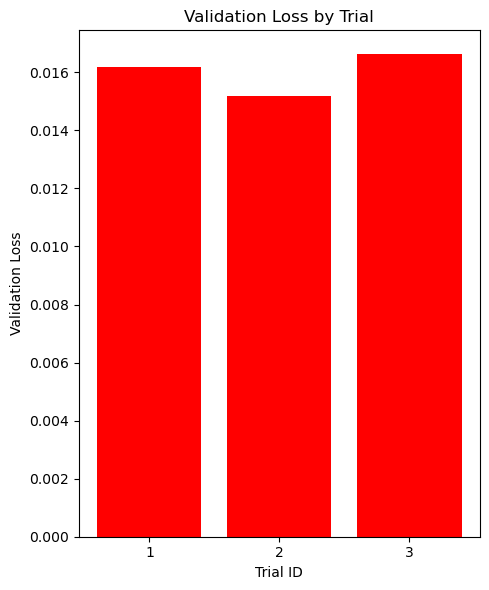

In [ ]:
df_results = tuner_results_to_dataframe(tuner)
print("df_results")
print(df_results)

filtered_df = df_results.dropna(subset=['directional_accuracy'])

# Tracer les métriques
plt.figure(figsize=(14, 6))

# Tracer la Directional Accuracy si elle est disponible dans le dataframe filtré
if not filtered_df.empty and 'directional_accuracy' in filtered_df.columns:
    plt.subplot(1, 2, 1)
    plt.bar(filtered_df['trial_id'], filtered_df['directional_accuracy'], color='blue')
    plt.title("Directional Accuracy by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Directional Accuracy")

# Tracer le Training Loss si disponible
if 'loss' in df_results.columns:
    plt.subplot(1, 3, 2)  # Ajoutez ce nouveau subplot en deuxième position
    plt.bar(df_results['trial_id'], df_results['loss'], color='green')
    plt.title("Training Loss by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Training Loss")

# Tracer la Validation Loss si elle est disponible dans le dataframe
if 'val_loss' in df_results.columns:
    plt.subplot(1, 3, 3)  # Changez 1, 2 en 1, 3 pour ce subplot
    plt.bar(df_results['trial_id'], df_results['val_loss'], color='red')
    plt.title("Validation Loss by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Validation Loss")

plt.tight_layout()
plt.show()

Available metrics for trial 0: []
directional_accuracy not available for trial 0
val_loss not available for trial 0
Available metrics for trial 1: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 1
Available metrics for trial 2: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 2
Available metrics for trial 3: ['loss', 'main_output_loss', 'aux_output_loss', 'main_output_directional_accuracy', 'val_loss', 'val_main_output_loss', 'val_aux_output_loss', 'val_main_output_directional_accuracy']
directional_accuracy not available for trial 3
Available metrics for trial 4: []
directional_accuracy not available for trial 4
val_loss not availab

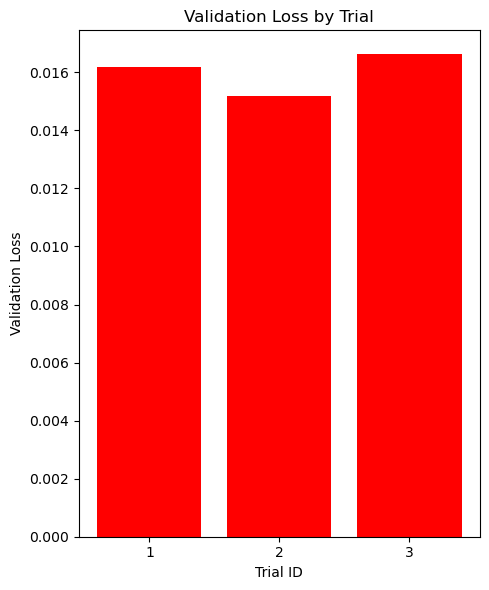

In [ ]:
df_results = tuner_results_to_dataframe(tuner)
print("df_results")
print(df_results)

filtered_df = df_results.dropna(subset=['directional_accuracy'])

# Tracer les métriques
plt.figure(figsize=(14, 6))

# Tracer la Directional Accuracy si elle est disponible dans le dataframe filtré
if not filtered_df.empty and 'directional_accuracy' in filtered_df.columns:
    plt.subplot(1, 2, 1)
    plt.bar(filtered_df['trial_id'], filtered_df['directional_accuracy'], color='blue')
    plt.title("Directional Accuracy by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Directional Accuracy")

# Tracer le Training Loss si disponible
if 'loss' in df_results.columns:
    plt.subplot(1, 3, 2)  # Ajoutez ce nouveau subplot en deuxième position
    plt.bar(df_results['trial_id'], df_results['loss'], color='green')
    plt.title("Training Loss by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Training Loss")

# Tracer la Validation Loss si elle est disponible dans le dataframe
if 'val_loss' in df_results.columns:
    plt.subplot(1, 3, 3)  # Changez 1, 2 en 1, 3 pour ce subplot
    plt.bar(df_results['trial_id'], df_results['val_loss'], color='red')
    plt.title("Validation Loss by Trial")
    plt.xlabel("Trial ID")
    plt.ylabel("Validation Loss")

plt.tight_layout()
plt.show()

In [203]:
# Obtenez la configuration du meilleur modèle
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# Reconstruisez le modèle à partir de ces hyperparamètres
new_model = actual_build_model(best_hyperparameters)

train_errors = []
val_errors = []

# Configuration de l'arrêt anticipé
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entraînement du modèle avec l'arrêt anticipé
history = new_model.fit(trainXS, trainYS, batch_size=hps['batch_size'], 
                        validation_data=(testXS, testYS), verbose=1, callbacks=[early_stopping])

# Récupérez les erreurs
train_errors = history.history['loss']
val_errors = history.history['val_loss']
    
# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Loss', color='blue')
plt.plot(val_errors, label='Validation Loss', color='red')

# Titre et labels
plt.title('Train vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200 - Train Loss: 1.2954, Validation Loss: 0.0184
Epoch 2/200 - Train Loss: 0.0523, Validation Loss: 0.0186
Epoch 3/200 - Train Loss: 0.0570, Validation Loss: 0.0339
Epoch 4/200 - Train Loss: 0.0636, Validation Loss: 0.0608
Epoch 5/200 - Train Loss: 0.0691, Validation Loss: 0.0416
Epoch 6/200 - Train Loss: 0.0689, Validation Loss: 0.0238


KeyboardInterrupt: 

384272
511
752
379673
380184
379673
379733
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 381ms/step
prediction_points [285]


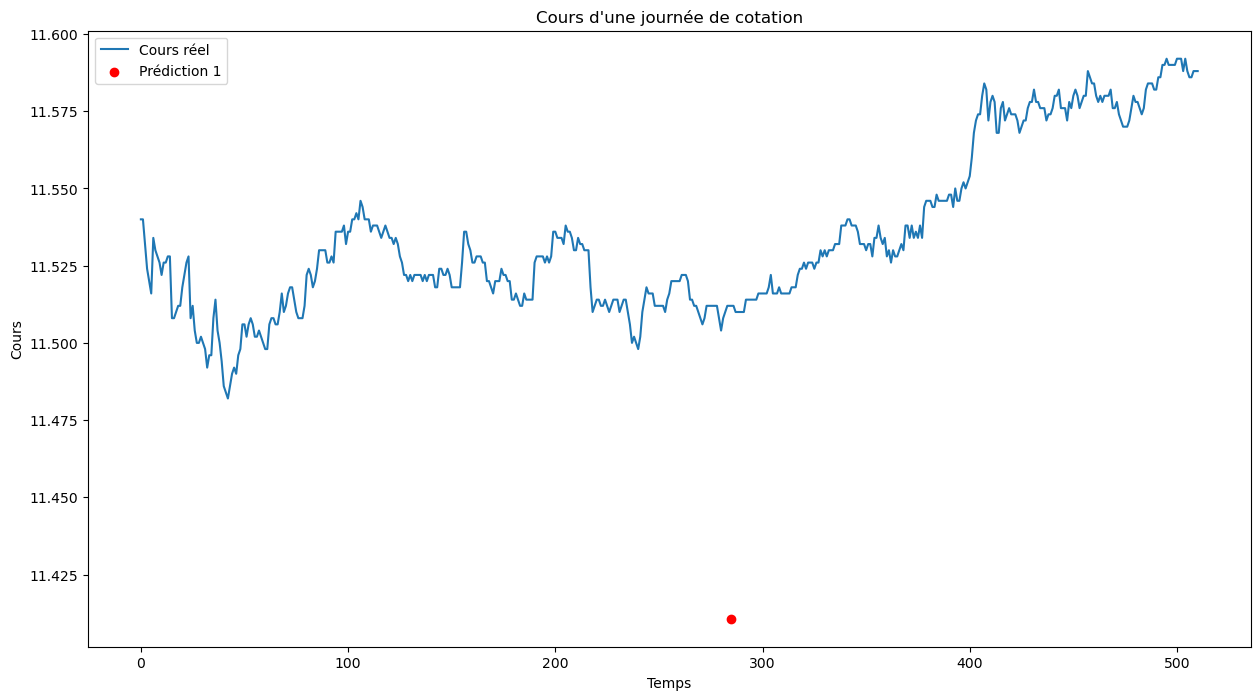

In [202]:
nb_quots_by_day = data_info['nb_quots_by_day']
look_back_x = data_info['look_back_x']
stride_x = data_info['stride_x']
nb_y = data_info['nb_y']

print( len(df))
print( nb_quots_by_day)
print( (len(df) // nb_quots_by_day))
num_day = (len(df) // nb_quots_by_day) - 9
quots_start = num_day * nb_quots_by_day
quots_end =  (num_day+1) * nb_quots_by_day

print(quots_start)
print(quots_end)

plt.close()  # Ferme le graphique actuel

plt.figure(figsize=(15,8))
plt.plot(df['openPrice'].iloc[quots_start:quots_end].values, label='Cours réel')
plt.title('Cours d\'une journée de cotation')
plt.xlabel('Temps')
plt.ylabel('Cours')

test_start = quots_start
test_end = quots_start + look_back_x * stride_x

print(test_start)
print(test_end)

X_pred = df.iloc[test_start:test_end:stride_x, :]

X_pred = X_pred.values.reshape(look_back_x, -1)  # Remodelage pour que cela corresponde à l'entrée attendue par le modèle

# Create a copy of the original data to transform
X_predS = np.copy(X_pred)
for i, scaler in enumerate(scalers): 
    X_predS[:, i] = scaler.transform(X_pred.reshape(-1, 1)).flatten()
  
print(X_predS.shape)

X_predS = X_predS.reshape(1,look_back_x,-1)
print(X_predS.shape)


y_pred = new_model.predict(X_predS)
y_pred_original = scalers[open_price_index].inverse_transform(y_pred)


# Les points où les prédictions sont faites
prediction_points = []
for i in range(1, nb_y+1):
    offset = i * ((nb_quots_by_day - look_back_x*stride_x) // (nb_y+1))
    prediction_points.append(test_end - test_start + offset)
    
print("prediction_points", prediction_points)
# Ajout des prédictions au graphique
for idx, value in enumerate(y_pred_original[0]):
    plt.scatter(prediction_points[idx], value, color='red', label='Prédiction {}'.format(idx+1))
plt.legend()
plt.show()



In [14]:
# 2. Prédire la même valeur que le dernier échantillon
# Supposant que la première caractéristique dans "features" est celle que nous voulons prédire.
last_value_predictions = testXS[:, -1, 0]
mse_last_value = mean_squared_error(testYS[:, 0], last_value_predictions)
print(f"MSE en utilisant la dernière valeur de chaque séquence: {mse_last_value:.5f}")

# Comparaison avec le meilleur modèle LSTM
best_mse_lstm = df_results['Score (val_loss)'].min()
print(f"Meilleur MSE pour le modèle LSTM: {best_mse_lstm:.5f}")

print("\nRésultats:")
print(f"Amélioration par rapport à la prédiction de la dernière valeur: {mse_last_value - best_mse_lstm:.5f}")

MSE en utilisant la dernière valeur de chaque séquence: 0.03071
Meilleur MSE pour le modèle LSTM: 0.24121

Résultats:
Amélioration par rapport à la prédiction de la dernière valeur: -0.21050


In [79]:
trainXS.shape

(737, 60, 2)

In [78]:
trainYS.shape

(737, 1, 2)

In [36]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Exemple de données
dates = pd.date_range(start='2022-01-01', periods=100, freq='D')
values = np.random.randn(100)

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=values, mode='lines', name='Random Data'))

fig.update_xaxes(
    rangeslider=dict(visible=True),
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.update_layout(
    title='Test Range Selector',
    xaxis_title='Date',
    yaxis_title='Value',
)

fig.show()